## Image Style Transfer Using Convolutional Neural Networks
* Gatys et al. - CVPR 2016
* paper : http://ieeexplore.ieee.org/document/7780634/

### Import modules

In [1]:
import os
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
import torch
import torchvision

import torchvision.models as models
import torchvision.transforms as transforms

### Set flags

In [3]:
gpu_device_no = 1
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_device_no)

vgg_flag = 19

### Set dependent parameters and load model

In [4]:
if vgg_flag == 16:
    style_layers = [3, 8, 15, 22] # relu1_2, relu2_2, relu3_3, relu4_3
    content_layers = [15] # relu3_3
    imsize = 256    
    vgg = models.vgg16(pretrained=True).features
        
elif vgg_flag == 19:
    style_layers = [1, 6, 11, 20, 29] # relu1_1, relu2_1, relu3_1, relu4_1, relu5_1
    content_layers = [22] # relu4_2
    imsize = 512    
    vgg = models.vgg19(pretrained=True).features
else:
    raise RuntimeError("Not exptected vgg_flag !!!")
    
for param in vgg.parameters():
    param.requires_grad = False

if gpu_device_no >= 0:
    vgg = vgg.cuda()

### Utility functions

In [5]:
# (de) normalize with Mean, Std of IMAGENET
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

denormalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                 std=[1/0.229, 1/0.224, 1/0.225])

unloader = transforms.ToPILImage()

def imload(path, imsize=256):
    transform_ = list()
    transformer = transforms.Compose([
        transforms.Resize(imsize),
        transforms.ToTensor(),
        normalize
    ])
    return transformer(Image.open(path)).unsqueeze(0)

def imshow(tensor):
    if tensor.is_cuda:
        tensor = tensor.cpu()        
    tensor = torchvision.utils.make_grid(tensor)
    tensor = denormalize(tensor)
    image = unloader(tensor.clamp_(0.0, 1.0))
    plt.imshow(image)
    plt.show()
    return None

In [6]:
mse_criterion = torch.nn.MSELoss(reduction='mean')

def calc_Content_Loss(features, targets, weights=None):
    if weights is None:
        weights = [1/len(features)] * len(features)
    
    content_loss = 0
    for f, t, w in zip(features, targets, weights):
        content_loss += mse_criterion(f, t) * w
        
    return content_loss

def calc_Gram_Loss(features, targets, weights=None):
    if weights is None:
        weights = [1/len(features)] * len(features)
        
    gram_loss = 0
    for f, t, w in zip(features, targets, weights):
        gram_loss += mse_criterion(gram(f), gram(t)) * w
    return gram_loss

def calc_TV_Loss(x):
    tv_loss = torch.sum(torch.abs(x[:, :, :, :-1] - x[:, :, :, 1:]))
    tv_loss += torch.sum(torch.abs(x[:, :, :-1, :] - x[:, :, 1:, :]))
    return tv_loss

In [7]:
def extract_features(model, x, layers):
    features = list()
    for index, layer in enumerate(model):
        x = layer(x)
        if index in layers:
            features.append(x)
    return features

def gram(x):
    b ,c, h, w = x.size()
    g = torch.bmm(x.view(b, c, h*w), x.view(b, c, h*w).transpose(1,2))
    return g.div(h*w)

### Load content and style images

In [8]:
content_path = 'content_sample.jpg'
style_path = '../test-image-dataset/style-images/mondrian.jpg'

content_image = imload(content_path, imsize=imsize)
style_image = imload(style_path, imsize=imsize)

if gpu_device_no >= 0:
    content_image = content_image.cuda()
    style_image = style_image.cuda()

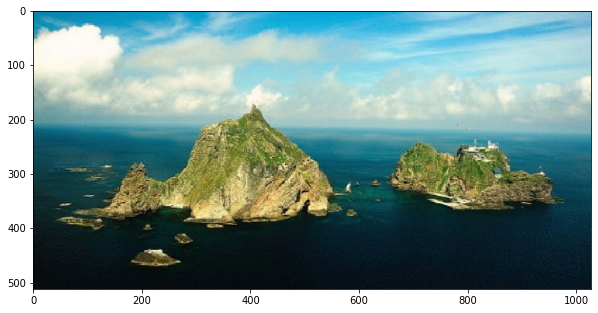

In [9]:
plt.figure(figsize=(10,10))
imshow(content_image)

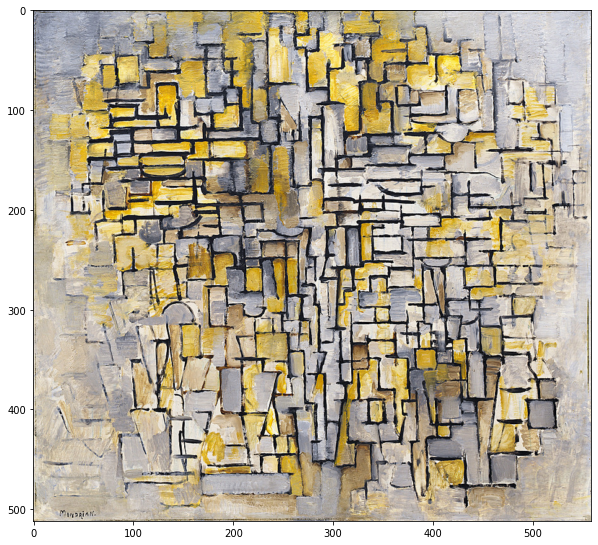

In [10]:
plt.figure(figsize=(10,10))
imshow(style_image)

### Image Stylization Function

In [11]:
def stylize_image(vgg,
                  content_image, style_image, 
                  content_weight, style_weight, tv_weight,
                  content_layers, style_layers,
                  learning_rate, training_iteration,
                  input_content_ratio=0):
    
    # input image
    input_image = torch.randn_like(content_image).cuda()
    input_image = input_image*(1- input_content_ratio) +  content_image.detach() * input_content_ratio
    
    # optimizer
    optimizer = torch.optim.LBFGS ([input_image.requires_grad_()], lr=learning_rate)

    # extract features
    target_content_features = extract_features(vgg, content_image, content_layers)
    target_style_features = extract_features(vgg, style_image, style_layers)
        
    for i in range(training_iteration):
        def closure():                    
            optimizer.zero_grad()
            
            input_content_features = extract_features(vgg, input_image, content_layers)
            input_style_features = extract_features(vgg, input_image, style_layers)
            
            # calculate losses
            content_loss = calc_Content_Loss(input_content_features, target_content_features)
            style_loss = calc_Gram_Loss(input_style_features, target_style_features)
            tv_loss = calc_TV_Loss(input_image)
            
            total_loss = content_loss * content_weight + style_loss * style_weight + tv_loss * tv_weight
                            
            # optimization
            total_loss.backward()
            
            return total_loss
        
        # optimization
        optimizer.step(closure)
                
    return input_image

### Image Stylization

In [12]:
result = stylize_image(vgg=vgg, 
                       content_image=content_image, style_image=style_image, 
                       content_weight=1, style_weight=100, tv_weight=5e-6,
                       content_layers=content_layers, style_layers=style_layers,
                       learning_rate=1, training_iteration=300, input_content_ratio=0.5)

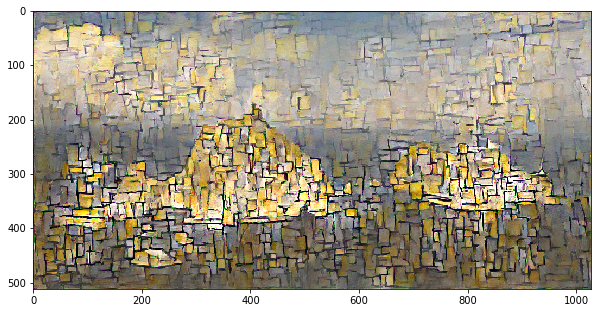

In [13]:
plt.figure(figsize=(10,10))
imshow(result.data)